In [1]:
import torch
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import trange
import numpy as np
import matplotlib.pyplot as plt

from gnncloudmanufacturing.data import read_fatahi_dataset
from gnncloudmanufacturing.mip_solver import mip_solve
from gnncloudmanufacturing.validation import objvalue, construct_delta
from gnncloudmanufacturing.graph import dglgraph, graph_gamma, os_type, ss_type, so_type
from gnncloudmanufacturing.graphconv import GNN

In [2]:
dataset = read_fatahi_dataset('../data/fatahi.xlsx')
len(dataset)

  0%|          | 0/18 [00:00<?, ?it/s]

18

In [3]:
train_problem = dataset[0]
test_problem = dataset[2]
train_problem['name'], test_problem['name']

('5,10,10-1', '5,10,10-3')

In [4]:
delta, train_gamma, status, value = mip_solve(train_problem)
print(f'Problem {train_problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-1: 5086.08, OptimizationStatus.OPTIMAL


In [5]:
delta, test_gamma, status, value = mip_solve(test_problem)
print(f'Problem {test_problem["name"]}: {value:.2f}, {status}')

Problem 5,10,10-3: 7652.32, OptimizationStatus.FEASIBLE


In [6]:
train_graph = dglgraph(train_problem, train_gamma)
train_target = train_graph.edata['target'][os_type]
train_graph.edata['feat'][os_type][:, 0] /= 10
train_graph.edata['feat'][ss_type][:] /= 100

test_graph = dglgraph(test_problem, test_gamma)
test_target = test_graph.edata['target'][os_type]
test_graph.edata['feat'][os_type][:, 0] /= 10
test_graph.edata['feat'][ss_type][:] /= 100

In [15]:
model = GNN(ins_dim=1, ino_dim=train_problem['n_operations']+2, out_dim=16, n_layers=2)

In [16]:
train_loss = []
test_loss = []
train_objvalue = []
test_objvalue = []

In [17]:
optim = Adam(model.parameters(), lr=0.001)

for i in trange(1000):
    logits = model(train_graph)
    loss = F.binary_cross_entropy_with_logits(logits, train_target)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 1 == 0:
        with torch.no_grad():
            train_loss.append(loss.item())
            pred_gamma = model.predict(train_graph, train_problem)
            train_objvalue.append(
                objvalue(train_problem, pred_gamma, construct_delta(train_problem, pred_gamma))
            )
            logits = model(test_graph)
            loss = F.binary_cross_entropy_with_logits(logits, test_target)
            test_loss.append(loss.item())
            pred_gamma = model.predict(test_graph, test_problem)
            test_objvalue.append(
                objvalue(test_problem, pred_gamma, construct_delta(test_problem, pred_gamma))
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

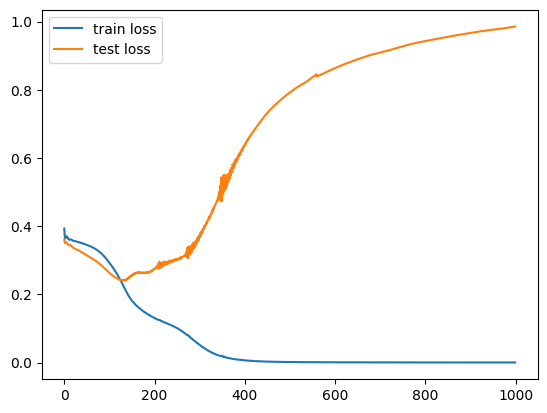

In [18]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

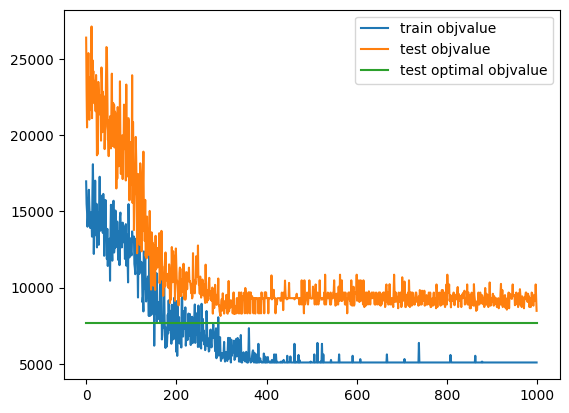

In [19]:
plt.plot(train_objvalue, label='train objvalue')
plt.plot(test_objvalue, label='test objvalue')
plt.plot([0, 1000], [value, value], label='test optimal objvalue')
plt.legend()
plt.show()

In [20]:
min(train_objvalue), min(test_objvalue)

(5086.083142240974, 8140.2002788175305)